In [288]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/Work/Developer/interpretDL/Pipeline")

In [285]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(16,8),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [8]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [9]:
raw_data.shape

(325, 335)

In [12]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
features.head()

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,58.659229,88.770279,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,57.548630,43.613918,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,11.748866,51.033894,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,47.578297,46.981075,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,149.398560,54.505650,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [37]:
labels = raw_data[label_cols].copy()
labels

,ASD_DX_group,Risk
CandID,,
103430,TYPICAL,HR
107524,ASD,HR
108372,TYPICAL,LR
113320,TYPICAL,LR
114640,TYPICAL,LR
118969,TYPICAL,HR
119906,TYPICAL,LR
121007,ATYPICAL_ADOS,HR
123794,TYPICAL,HR


In [17]:
labels["Risk"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [18]:
labels["ASD_DX_group"][labels["Risk"]=="LR"].value_counts()

TYPICAL            99
ATYPICAL_ADOS       7
ASD                 3
ATYPICAL_MULLEN     2
Name: ASD_DX_group, dtype: int64

In [50]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
LR_typical = labels[LR & typical]

In [51]:
HR = labels["Risk"]=="HR"
HR_nontypical = labels[HR & ~typical]

In [52]:
analysis_labels = pd.concat((LR_typical, HR_nontypical))
analysis_labels["Risk"].value_counts()

LR    99
HR    65
Name: Risk, dtype: int64

In [53]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [58]:
enc_labels[:,0]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 1., 0., 0., 1., 2., 0., 1.,
       0., 2., 2., 1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])

In [114]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

train_labels.value_counts()

1    79
0    52
dtype: int64

In [374]:
def build_dnn(num_features, num_labels, activation="elu", output_activation="sigmoid"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    
    dnn.add(Dense(units = 150, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation=output_activation,
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    SGD=keras.optimizers.SGD(lr=0.001)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [386]:
# dnn = build_dnn(num_features=data.shape[1], num_labels=1)
# dnn.summary()

In [361]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=100,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=200, batch_size=20, verbose=1, callbacks=[early_stop])

Train on 131 samples, validate on 33 samples
Epoch 1/200
131/131 [==============================] - 0s 2ms/step - loss: 36.2978 - acc: 0.4656 - val_loss: 35.8882 - val_acc: 0.5152
Epoch 2/200
131/131 [==============================] - 0s 87us/step - loss: 36.0500 - acc: 0.5267 - val_loss: 35.5894 - val_acc: 0.5152
Epoch 3/200
131/131 [==============================] - 0s 79us/step - loss: 35.6343 - acc: 0.5344 - val_loss: 35.2431 - val_acc: 0.5152
Epoch 4/200
131/131 [==============================] - 0s 105us/step - loss: 35.2617 - acc: 0.5267 - val_loss: 34.8764 - val_acc: 0.5455
Epoch 5/200
131/131 [==============================] - 0s 111us/step - loss: 34.8192 - acc: 0.5725 - val_loss: 34.5091 - val_acc: 0.5455
Epoch 6/200
131/131 [==============================] - 0s 121us/step - loss: 34.3563 - acc: 0.7023 - val_loss: 34.1409 - val_acc: 0.6061
Epoch 7/200
131/131 [==============================] - 0s 100us/step - loss: 33.9414 - acc: 0.7252 - val_loss: 33.7780 - val_acc: 0.6061


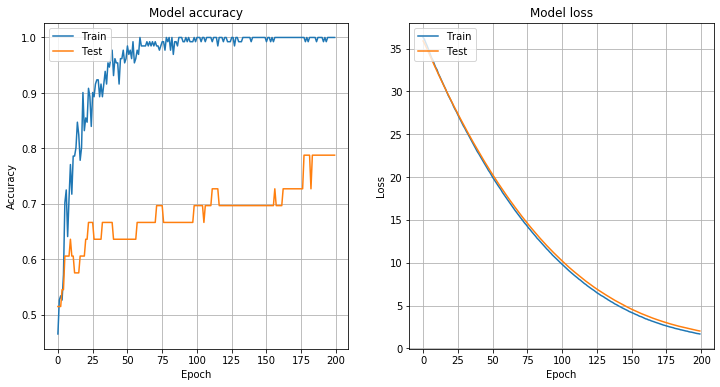

33/33 [==============================] - 0s 48us/step
Loss:2.027, Acc:0.7879


In [363]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

In [283]:
# np.ravel(dnn.predict(X_valid))

Confusion matrix, without normalization
[[0.69230769 0.30769231]
 [0.15       0.85      ]]
Overall Accuracy: 0.7879


(<matplotlib.axes._subplots.AxesSubplot at 0x1a4d899240>, array([[ 9,  4],
        [ 3, 17]]))

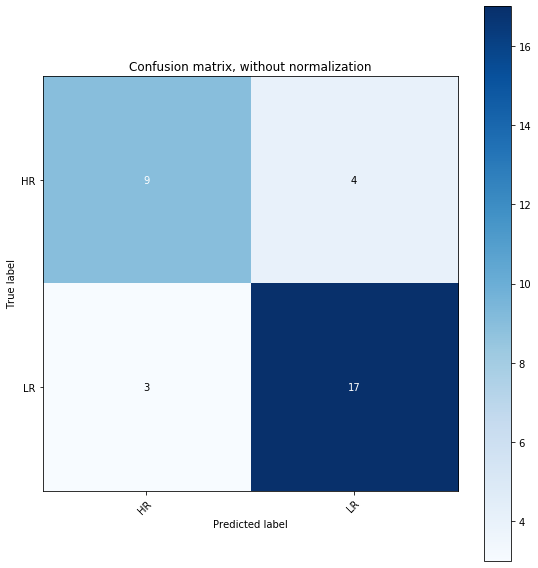

In [364]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [277]:
val_samples = analysis_labels.loc[test_labels.index]
val_samples["DNN Pred"] = y_pred
val_samples[val_samples["Risk"]=="HR"]

,ASD_DX_group,Risk,DNN Pred
CandID,,,
526558,ASD,HR,0.0
950194,ASD,HR,0.0
321541,ASD,HR,0.0
857317,ASD,HR,1.0
751794,ASD,HR,1.0
677040,ATYPICAL_MULLEN,HR,0.0
402809,ASD,HR,0.0
389521,ASD,HR,1.0
456823,ASD,HR,0.0


In [326]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu", output_activation="sigmoid")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=250, batch_size=20, verbose=0)

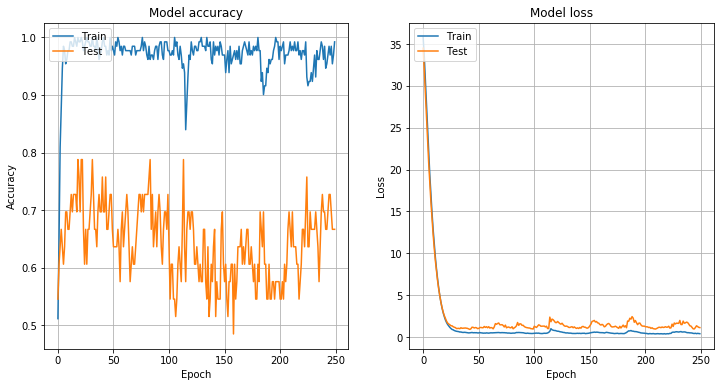

33/33 [==============================] - 0s 63us/step
Loss:1.118, Acc:0.6667


In [327]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))